In [1]:
# Project: CrimesDelits
# Creation Date: 2023-10-11
# History:
######################################################################################################################################################
#   DATE            AUTHOR      VERSION     ACTION
#   2023-10-11      LLEG        1.0.0       Creation

import time
import logging
import warnings

from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import geopandas as gpd
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

from utils.log_config import Logging
from utils.constant import Constant
from utils.functions import download_file, read_xlsx

c:\Users\clemj\OneDrive\Documents\M2_MIASHS\Clémentine\Projet\crimes-delits\utils\constant.py:27: SyntaxWarning: invalid escape sequence '\c'
  GEOJSON_FILE = 'data\contour-des-departements.geojson'


In [1]:
# load logging config
Logging.create_log_folder()
Logging.load_logging_config("./conf/logging.json")
log = logging.getLogger(__name__)

In [1]:
starting_time = time.time()
log.debug('Start')

In [1]:
download_file(url=Constant.DATA_URL, filepath=Constant.DATA_FILE)
download_file(url=Constant.DOCUMENTATION_URL, filepath=Constant.DOCUMENTATION_FILE)
download_file(url=Constant.INSTRUCTIONS_URL, filepath=Constant.INSTRUCTIONS_FILE)
download_file(url=Constant.GEOJSON_URL, filepath=Constant.GEOJSON_FILE)

[INFO] 2023-12-11 14:03:10,117 utils.functions.download_file() 34: crimes-delits.xlsx file already exists
[INFO] 2023-12-11 14:03:10,144 utils.functions.download_file() 34: documentation.docx file already exists
[INFO] 2023-12-11 14:03:10,173 utils.functions.download_file() 34: instructions.pdf file already exists
[INFO] 2023-12-11 14:03:10,200 utils.functions.download_file() 34: contour-des-departements.geojson file already exists


In [1]:
dict_df = read_xlsx(Constant.DATA_FILE)

In [1]:
# check for Na
na_sum = 0
for key in dict_df.keys():
    na_sum += dict_df[key].loc[Constant.CHOSEN_INDEX, :].sum().isna().sum()

print(f"NaN sum for {Constant.CHOSEN_INDEX}: {na_sum}")

NaN sum for [34, 35, 36]: 0


In [1]:
# create dataframe with groupby on departements and selecting chosen crime
df = pd.DataFrame({key: value.T.groupby(level='Départements').sum().T.loc[Constant.CHOSEN_INDEX].sum() for key, value in dict_df.items()}).T
df.columns.name = None
df.fillna(0, inplace=True)

df.insert(0, 'year', np.int_)
df.insert(1, 'services', np.int_)
df.insert(2, 'total', np.int_)

for index, row in df.iterrows():
    df.loc[index, 'year'] = index[-4:]
    df.loc[index, 'services'] = index[9:11]
    df.loc[index, 'total'] = row.drop(['year', 'services', 'total']).sum()
    
df.sort_values('year', inplace=True)
df.reset_index(inplace=True, drop=True)

df

,year,services,total,01,02,03,04,05,06,07,...,95,971,972,973,974,976,978,986,987,988
0,2012,PN,125727.0,121.0,526.0,294.0,147.0,103.0,5965.0,150.0,...,4476.0,569.0,388.0,277.0,768.0,148.0,0.0,0.0,124.0,675.0
1,2012,GN,57930.0,1057.0,782.0,147.0,251.0,101.0,946.0,526.0,...,1529.0,575.0,320.0,219.0,622.0,0.0,427.0,8.0,110.0,432.0
2,2013,GN,56972.0,835.0,768.0,127.0,234.0,88.0,758.0,507.0,...,1302.0,495.0,317.0,295.0,652.0,0.0,551.0,5.0,133.0,580.0
3,2013,PN,122159.0,127.0,545.0,283.0,126.0,98.0,4743.0,178.0,...,4664.0,450.0,368.0,434.0,790.0,225.0,0.0,0.0,141.0,675.0
4,2014,GN,55280.0,959.0,730.0,177.0,207.0,69.0,697.0,467.0,...,1284.0,522.0,318.0,261.0,595.0,0.0,416.0,3.0,122.0,561.0
5,2014,PN,119709.0,140.0,435.0,271.0,114.0,132.0,4444.0,191.0,...,4422.0,429.0,427.0,538.0,812.0,303.0,0.0,0.0,161.0,661.0
6,2015,GN,55453.0,1167.0,661.0,119.0,229.0,66.0,575.0,445.0,...,1464.0,569.0,260.0,301.0,701.0,0.0,387.0,1.0,253.0,587.0
7,2015,PN,118900.0,151.0,469.0,277.0,115.0,87.0,3537.0,155.0,...,4074.0,435.0,332.0,531.0,925.0,344.0,0.0,0.0,182.0,658.0
8,2016,PN,112748.0,156.0,440.0,311.0,153.0,124.0,3046.0,160.0,...,4144.0,411.0,361.0,550.0,947.0,248.0,0.0,0.0,160.0,655.0
9,2016,GN,55326.0,1149.0,665.0,216.0,213.0,117.0,542.0,471.0,...,1317.0,561.0,252.0,366.0,929.0,0.0,389.0,2.0,202.0,712.0


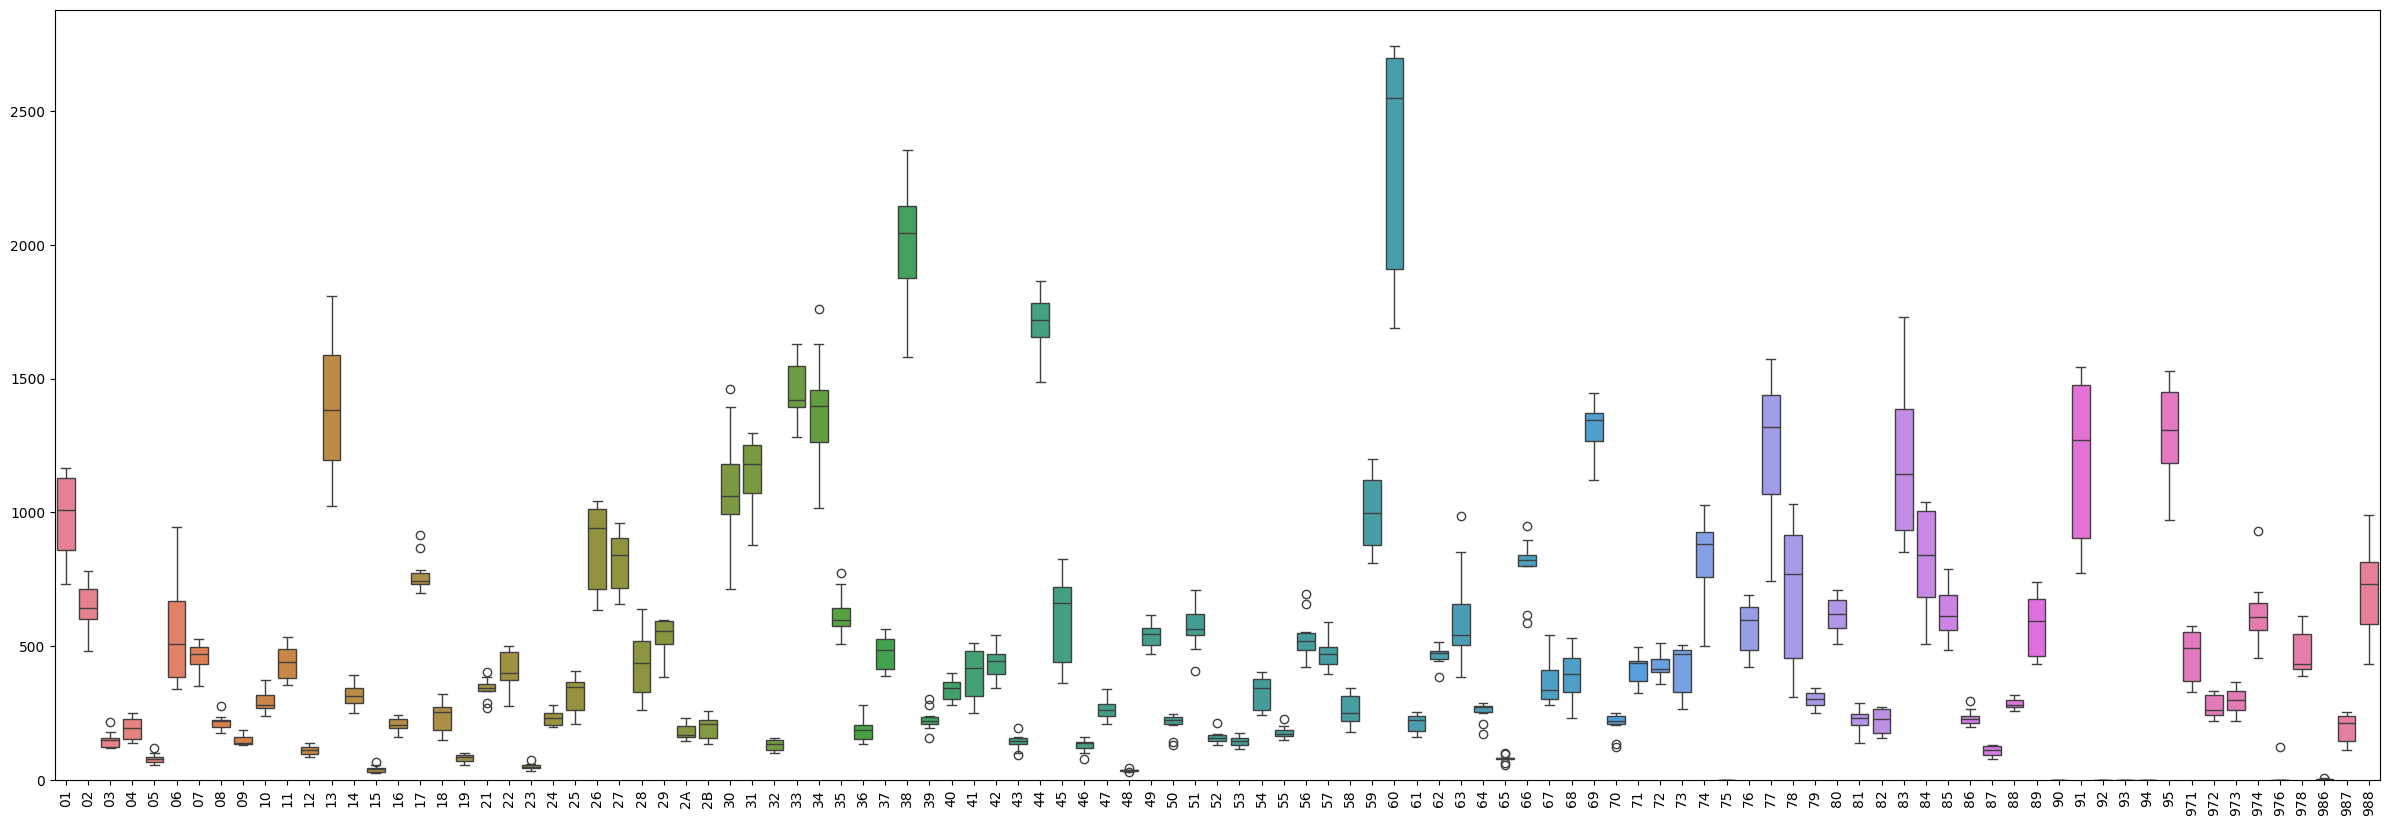

In [1]:
# plot boxplots of chosen service and crime
_, ax = plt.subplots(figsize=(30, 10))
sns.boxplot(data=df.drop(['year', 'total'], axis=1)[df['services'] == Constant.SERVICE])
plt.xticks(rotation=90)
ax.set(ylim=(0))
plt.show()

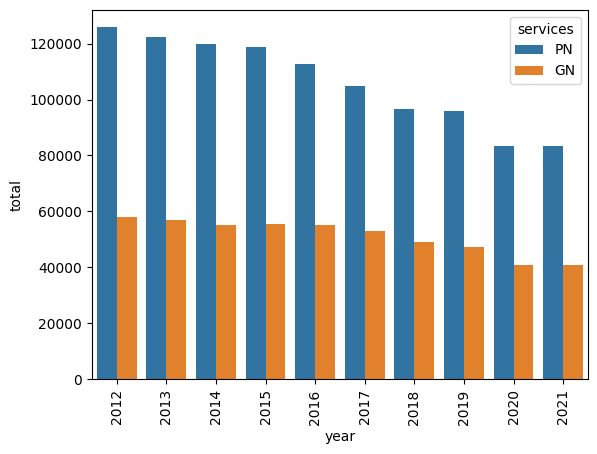

In [1]:
# plot total of index of choice by year
sns.barplot(data=df, x="year", y="total", hue="services", order=sorted(df["year"]))
plt.xticks(rotation=90)
plt.show()

In [1]:
# Read file with geopandas
geo_df = gpd.read_file(Constant.GEOJSON_FILE)

# Plot PN 2012 heatmap
geo_df['Services PN 2012'] = np.int_
for index, row in geo_df.iterrows():
    geo_df.loc[index, 'Services PN 2012'] = round(df[(df['services'] == Constant.SERVICE) & (df['year'] == '2012')][row['code']].iloc[0] / df.drop(['year', 'services', 'total'], axis=1)[(df['services'] == Constant.SERVICE) & (df['year'] == '2012')].max().max(), 3)

<Axes: >

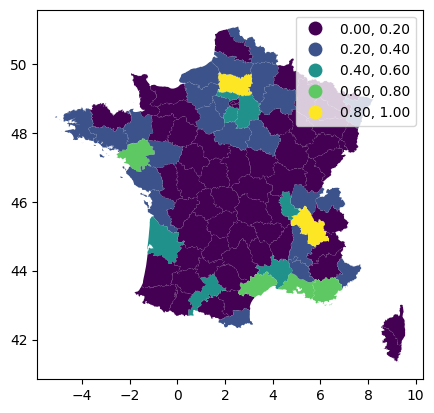

In [1]:
geo_df.plot(column='Services PN 2012', legend=True, scheme="prettybreaks")

In [1]:
df.rename(columns={'year': 'ds', 'total': 'y'}, inplace=True)

In [1]:
df_PN = df[df['services'] == Constant.SERVICE]

In [1]:
df_PN.index = pd.DatetimeIndex(df_PN.ds)
df_PN = df_PN.drop('ds', axis=1)

In [1]:
df_train = df_PN[df_PN.index < Constant.TRAIN_TEST_SPLIT_YEAR]
df_test = df_PN[df_PN.index >= Constant.TRAIN_TEST_SPLIT_YEAR]

In [1]:
warnings.filterwarnings("ignore")

[INFO] 2023-12-11 12:47:51,603 __main__.<module>() 63: AR RMSE: 7427.639184886182, AR R²: nan
[INFO] 2023-12-11 12:47:51,610 __main__.<module>() 64: ARIMA RMSE: 5841.170711123588, ARIMA R²: nan
[INFO] 2023-12-11 12:47:51,617 __main__.<module>() 65: SMA RMSE: 35.29368407898437, SMA R²: nan
[INFO] 2023-12-11 12:47:51,656 __main__.<module>() 66: EMA RMSE: 3952.937130090082, EMA R²: nan
[INFO] 2023-12-11 12:47:51,665 __main__.<module>() 67: MLP RMSE: 609.5465099099893, MLP R²: nan


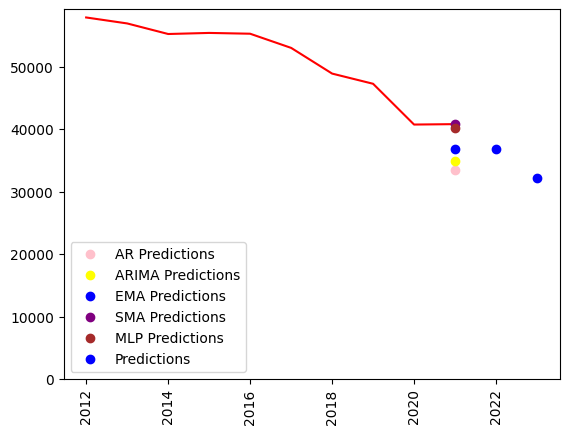

In [1]:
# plot existing data
plt.plot(df_PN.index,df_PN['y'],color='red')
#plt.plot(df_train.index, df_train['y'], color="black")
#plt.plot(df_test.index, df_test['y'], color="red")
plt.xticks(rotation=90)

y = df_train['y'].astype(int)
arima_model = ARIMA(y, order = (3, 2, 2))
arima_model = arima_model.fit()

# AR Model
ar_model = AutoReg(df_train['y'].astype(int), 1).fit()
y_pred_ar = ar_model.forecast(len(df_test))

# ARIMA Predictions
y_pred_arima = arima_model.get_forecast(len(df_test.index))
y_pred_df_arima = y_pred_arima.conf_int(alpha = 0.05) 
y_pred_df_arima["Predictions"] = arima_model.predict(start = y_pred_df_arima.index[0], end = y_pred_df_arima.index[-1])

# Simple Moving Average (SMA)
sma_model = SimpleExpSmoothing(df_train['y'].astype(int)).fit()
y_pred_sma = sma_model.forecast(len(df_test))

# Exponential Moving Average (EMA)
ema_model = ExponentialSmoothing(df_train['y'].astype(int), trend='add', damped_trend=True).fit()
y_pred_ema = ema_model.forecast(len(df_test))

# MLPRegressor
mlp_model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000)
mlp_model.fit(df_train.drop(['services'], axis=1), df_PN.loc['2013': Constant.TRAIN_TEST_SPLIT_YEAR, 'y'])
y_pred_mlp = mlp_model.predict(df_test.drop(['services'], axis=1))

# plot predictions
plt.plot(df_test.index, y_pred_ar ,'o', color='pink', label='AR Predictions')
plt.plot(df_test.index, y_pred_df_arima["Predictions"] ,'o', color='Yellow', label='ARIMA Predictions')
plt.plot(df_test.index, y_pred_ema,'o', color='blue', label='EMA Predictions')
plt.plot(df_test.index, y_pred_sma,'o', color='purple', label='SMA Predictions')
plt.plot(df_test.index, y_pred_mlp,'o', color='brown', label='MLP Predictions')

# ema_model = ExponentialSmoothing(df_PN['y'].astype(int), trend='add', damped_trend=True).fit()
# y_pred_ema = ema_model.forecast(1)
plt.plot(pd.date_range('2022', freq='AS', periods=2), ema_model.forecast(2), 'o', color='blue', label='Predictions')

plt.legend()
plt.ylim(0,)

# metrics
ar_rmse = np.sqrt(mean_squared_error(df_test["y"].values, y_pred_ar))
r2_ar = r2_score(df_test["y"].values, y_pred_ar)

arma_rmse = np.sqrt(mean_squared_error(df_test["y"].values, y_pred_df_arima["Predictions"]))
r2_arma = r2_score(df_test["y"].values, y_pred_df_arima["Predictions"])

sma_rmse = np.sqrt(mean_squared_error(df_test["y"].values, y_pred_sma))
r2_sma = r2_score(df_test["y"].values, y_pred_sma)

ema_rmse = np.sqrt(mean_squared_error(df_test["y"].values, y_pred_ema))
r2_ema = r2_score(df_test["y"].values, y_pred_ema)

mlp_rmse = np.sqrt(mean_squared_error(df_test["y"].values, y_pred_mlp))
r2_mlp = r2_score(df_test["y"].values, y_pred_mlp)

log.info("AR RMSE: %s, AR R²: %s", ar_rmse, r2_ar)
log.info("ARIMA RMSE: %s, ARIMA R²: %s", arma_rmse, r2_arma)
log.info("SMA RMSE: %s, SMA R²: %s", sma_rmse, r2_sma)
log.info("EMA RMSE: %s, EMA R²: %s", ema_rmse, r2_ema)
log.info("MLP RMSE: %s, MLP R²: %s", mlp_rmse, r2_mlp)

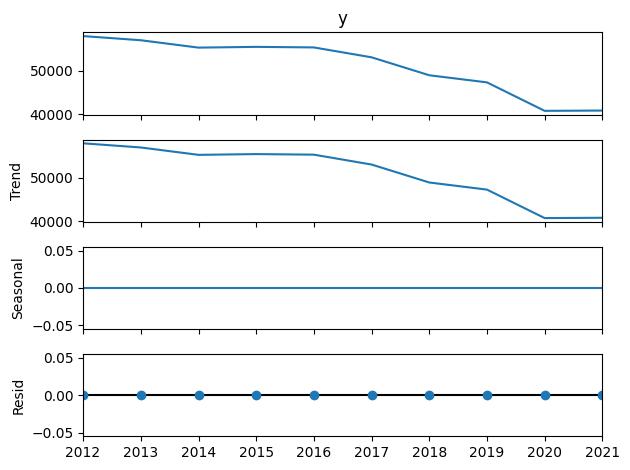

In [1]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(df_PN['y'], model='additive')
fig = decomposition.plot()
plt.show()


In [1]:
# Cross validation for MLP Model
X = df_train.drop(['services', 'y'], axis=1)
y = df_train['y']

scorer = make_scorer(r2_score)
cv_scores = cross_val_score(mlp_model, X, y, cv=3, scoring=scorer)

log.info("Scores de Validation Croisée: %s", cv_scores)
log.info("RMSE Moyen: %s", np.mean(cv_scores))

[INFO] 2023-12-11 12:48:05,225 __main__.<module>() 8: Scores de Validation Croisée: [0.99519548 0.88659366 0.99311064]
[INFO] 2023-12-11 12:48:05,238 __main__.<module>() 9: RMSE Moyen: 0.9582999266631819


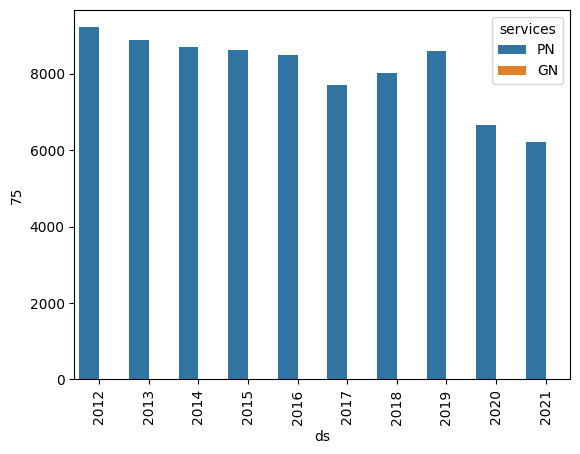

In [1]:
# Paris crime evolution
sns.barplot(data=df, x="ds", y="75", hue="services", order=sorted(df["ds"]))
plt.xticks(rotation=90)
plt.show()

In [1]:
pred = '2022'
arma_rmse, r2_arma = 0, 0
sma_rmse, r2_sma = 0, 0
ema_rmse, r2_ema = 0, 0
mlp_rmse, r2_mlp = 0, 0
geo_def_pred = gpd.read_file(Constant.GEOJSON_FILE)
geo_def_pred[f'Services {Constant.SERVICE} {pred}'] = np.int_
variation = {}

for dept in tqdm(df_train.drop(['services', 'y'], axis=1).columns) :
    y = df_train[dept].astype(int)
    
    # AR Model
    ar_model = AutoReg(df_train['y'].astype(int), 1).fit()
    y_pred_ar = ar_model.forecast(len(df_test))
    
    arima_model = ARIMA(y, order = (1, 2, 2))
    arima_model = arima_model.fit()

    # ARIMA Predictions
    y_pred_arima = arima_model.get_forecast(len(df_test.index))
    y_pred_df_arima = y_pred_arima.conf_int(alpha = 0.05) 
    y_pred_df_arima["Predictions"] = arima_model.predict(start = y_pred_df_arima.index[0], end = y_pred_df_arima.index[-1])

    # Simple Moving Average (SMA)
    sma_model = SimpleExpSmoothing(df_train[dept].astype(int)).fit()
    y_pred_sma = sma_model.forecast(len(df_test))

    # Exponential Moving Average (EMA)
    ema_model = ExponentialSmoothing(df_train[dept].astype(int)).fit()
    y_pred_ema = ema_model.forecast(len(df_test))

    # MLPRegressor
    mlp_model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000)
    mlp_model.fit(df_train.drop(['services'], axis=1), df_train['y'])
    y_pred_mlp = mlp_model.predict(df_test.drop(['services'], axis=1))

    # metrics
    
    ar_rmse = np.sqrt(mean_squared_error(df_test["y"].values, y_pred_ar))
    r2_ar = r2_score(df_test["y"].values, y_pred_ar)
    
    arma_rmse += np.sqrt(mean_squared_error(df_test[dept].values, y_pred_df_arima["Predictions"]))
    r2_arma += r2_score(df_test["y"].values, y_pred_df_arima["Predictions"])

    sma_rmse += np.sqrt(mean_squared_error(df_test[dept].values, y_pred_sma))
    r2_sma += r2_score(df_test["y"].values, y_pred_sma)

    ema_rmse += np.sqrt(mean_squared_error(df_test[dept].values, y_pred_ema))
    r2_ema += r2_score(df_test["y"].values, y_pred_ema)

    mlp_rmse += np.sqrt(mean_squared_error(df_test[dept].values, y_pred_mlp))
    r2_mlp += r2_score(df_test["y"].values, y_pred_mlp)
 
    #geo_def_pred.loc[geo_def_pred.index[geo_def_pred['code'] == dept], f'Services {Constant.SERVICE} {pred}'] = y_pred_ar[0]   
    #geo_def_pred.loc[geo_def_pred.index[geo_def_pred['code'] == dept], f'Services {Constant.SERVICE} {pred}'] = y_pred_df_arima[0]
    #geo_def_pred.loc[geo_def_pred.index[geo_def_pred['code'] == dept], f'Services {Constant.SERVICE} {pred}'] = y_pred_ema[0]
    #geo_def_pred.loc[geo_def_pred.index[geo_def_pred['code'] == dept], f'Services {Constant.SERVICE} {pred}'] = y_pred_mlp[0]
    geo_def_pred.loc[geo_def_pred.index[geo_def_pred['code'] == dept], f'Services {Constant.SERVICE} {pred}'] = y_pred_sma[0]

    variation[dept] = (y_pred_sma[0] - df_test[dept].values[0]) / df_test[dept].values[0]
    
log.info("AR RMSE: %s, AR R²: %s", ar_rmse / len(df_train.drop(['services', 'y'], axis=1).columns), r2_ar/ len(df_train.drop(['services', 'y'], axis=1).columns))
log.info("ARIMA RMSE: %s, ARIMA R²: %s", arma_rmse / len(df_train.drop(['services', 'y'], axis=1).columns), r2_arma / len(df_train.drop(['services', 'y'], axis=1).columns))
log.info("SMA RMSE: %s, SMA R²: %s", sma_rmse / len(df_train.drop(['services', 'y'], axis=1).columns), r2_sma / len(df_train.drop(['services', 'y'], axis=1).columns))
log.info("EMA RMSE: %s, EMA R²: %s", ema_rmse / len(df_train.drop(['services', 'y'], axis=1).columns), r2_ema / len(df_train.drop(['services', 'y'], axis=1).columns))
log.info("MLP RMSE: %s, MLP R²: %s", mlp_rmse / len(df_train.drop(['services', 'y'], axis=1).columns), r2_mlp / len(df_train.drop(['services', 'y'], axis=1).columns))

100%|██████████| 105/105 [01:45<00:00,  1.01s/it]

[INFO] 2023-12-11 13:44:08,309 __main__.<module>() 63: AR RMSE: 70.73942080843983, AR R²: nan
[INFO] 2023-12-11 13:44:08,322 __main__.<module>() 64: ARIMA RMSE: 61.42257105371138, ARIMA R²: nan
[INFO] 2023-12-11 13:44:08,333 __main__.<module>() 65: SMA RMSE: 45.40096871536982, SMA R²: nan
[INFO] 2023-12-11 13:44:08,346 __main__.<module>() 66: EMA RMSE: 49.8094962597344, EMA R²: nan
[INFO] 2023-12-11 13:44:08,361 __main__.<module>() 67: MLP RMSE: 41235.905756567896, MLP R²: nan


In [1]:
variation = dict(sorted(variation.items(), key=lambda item: item[1]))
print(variation)

{'976': -1.0, '46': -0.20408162702310587, '41': -0.1909385102177129, '84': -0.17770597223126253, '987': -0.1766945901207078, '973': -0.16538952741964602, '36': -0.14673913230460625, '28': -0.1438485019163705, '91': -0.13058343414190163, '85': -0.10466982346323177, '25': -0.10389610150933781, '988': -0.08893512757116691, '79': -0.08358070755188977, '56': -0.07403909829781316, '83': -0.0708833129643874, '70': -0.0681818083605983, '87': -0.06237816365090123, '27': -0.06058798384175673, '60': -0.0584632174668397, '38': -0.05594536173101975, '49': -0.05280722982482239, '35': -0.051089881948368304, '80': -0.04830059838442218, '44': -0.04761161823629514, '73': -0.046786563995248484, '53': -0.030395352326237052, '29': -0.027091846982314306, '89': -0.027027026456487073, '06': -0.025201045139784425, '2A': -0.024390241085756117, '54': -0.008264462686767145, '45': -0.007796534823461453, '31': -0.006260734042068996, '971': 0.00613497046788046, '14': 0.013058061544611251, '67': 0.022148275373631697,

In [1]:
geo_def_pred[f'Services {Constant.SERVICE} {pred}'] /= geo_def_pred[f'Services {Constant.SERVICE} {pred}'].max()

<Axes: >

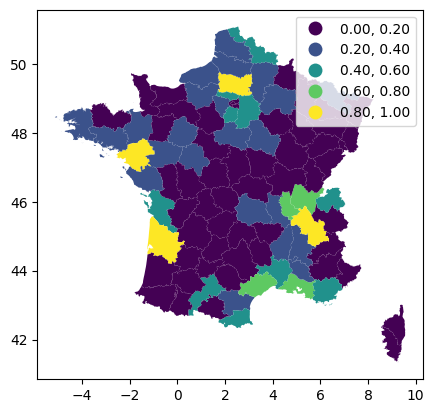

In [1]:
geo_def_pred.plot(column=f'Services {Constant.SERVICE} {pred}', legend=True, scheme="prettybreaks")

In [1]:
log.debug('End')
log.info('Finished successfully in %.2fs', time.time() - starting_time)

[INFO] 2023-12-11 12:50:08,397 __main__.<module>() 2: Finished successfully in 196.43s
